#**Project Description**

This project focuses on understanding the connection between network latency and geographical distance. By collecting and examining data from diverse servers across the globe, I aim to identify any consistent patterns or trends in how latency changes with distance. Utilizing statistical analysis and data visualization techniques, I will visually represent this relationship to gain deeper insights and evaluate the results. Ultimately, the goal is to shed light on how geographical distance impacts network performance.

The project consists 6 main parts:
1. Library Provision
2. Data Collection
3. Data Preparation and Visualization
4. Data Analysis
5. Model Evaluation
6. Conclusion


#**Part 1: Library Provision**

In this part, all the required libraries will be installed and imported into the notebook.

In [1]:
!pip install pythonping
!pip install --pre scapy[basic]
!pip install geopy
!pip install ip2geotools
!pip install pycountry_convert
!pip install folium

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [2]:
import urllib.request
import json
import socket
import numpy as np
import pandas as pd
import statistics
import pycountry_convert as pc
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from pythonping import ping
from scapy.all import *
from time import sleep
from geopy.distance import geodesic
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#**Part 2: Data Collection**

In the part 2, all the required data related to the reference server (my virtual machine Google Colab) and some Debian servers will be collected. The main parameters to do the investigation are:

* IP address
* Distance
* Latitude
* Longitude
* Continent
* Country
* City
* ***Round Trip Time***

I could find these parameters for my server with just a few lines of code but collecting these information for other servers needs much more effort, since I could not find a free and comprehensive dataset. Also, I need to compute the RTT by myself from my server to each specific and pingable server. Thus, collecting the information and building a dataset is crucial for this project. To do this, I use the links in https://www.debian.org/mirror/list which was suggested by the professor. You will see the complete process block by block which are provided by appropriate description.

get_continent is a function that gets a country name as input and finds its continent. If a continent is found for the input country's name, it will be returned, otherwise none will be returned.

In [3]:
def get_continent(country_name):
  try:
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name
  except:
    return "none"

This block of code fetches geographical information based on the IP address of the Colab VM, including the country, continent, city, and coordinates (latitude and longitude).

In [4]:
# Obtain the Colab VM's public IP address using a shell command curl
# The IP address is fetched from the website ipecho.net/plain.
colab_ip = !curl ipecho.net/plain
my_colab_ip = colab_ip[0]

# Fetch geographical information based on the Colab VM's IP address
info = urllib.request.urlopen('http://ip-api.com/json/' + my_colab_ip).read()

# Load the JSON response into a dictionary
my_info       = json.loads(info)

my_country    = my_info["country"]
my_continent  = get_continent(my_info["country"])
my_city       = my_info["city"]
my_latitude   = my_info["lat"]
my_longitude  = my_info["lon"]
my_coordinate = (my_latitude, my_longitude)

print(my_continent)
print(my_country)
print(my_city)
print(my_coordinate)

North America
United States
North Charleston
(32.8771, -80.013)


/usr/local/lib/python3.10/dist-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
/usr/local/lib/python3.10/dist-packages/pycountry/db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


This block of code is started with importing necessary libraries for web scraping and parsing HTML content. The webpage content is fetched from the "https://www.debian.org/mirror/list", parse the HTML content using BeautifulSoup, find all links on the webpage and extract the href attribute from each link. Finally, the extracted links are filtered to include only those containing '/debian/' in the URL.

In [5]:
import requests
from bs4 import BeautifulSoup

# URL of the webpage
url = "https://www.debian.org/mirror/list"

# Send a GET request to fetch the webpage content
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

# Find all links on the webpage
links = soup.find_all('a')

# Extract href attribute from each link
extracted_links = [link.get('href') for link in links]

# Filter links that contain /debian/
debian_links = [link for link in extracted_links if '/debian/' in link]

This function computes the Round-Trip Time (RTT) to a given IP address using ICMP ping. It sends ICMP ping requests to the target IP address, computes the average RTT in milliseconds if the ping is successful, and returns -1 if the ping fails or encounters an error. I consider the average RTT by sending 5 times ping to get more reliable RTT value.

In [6]:
def compute_rtt(ip_address):
  try:
    resp = ping(ip_address, count=5, timeout=5)
  except:
    resp = -1

  # If the ping is successful, take the average RTT and convert it to milliseconds and round it
  if resp.success:
    return round(resp.rtt_avg * 1000)
  else:
    return -1

This block of code collects data from Debian mirror links, including server IP addresses, geographical information, country, city, continent, distance from the reference server, and Round-Trip Time (RTT). It then creates a DataFrame and saves it to a CSV file named 'debian_servers_dataset.csv'. Since around 3000 information pieces should be fetched from different libraries, running this block of code will take some time (more than 20 minutes) due to applying 1 second delay at each iteration to avoid overloading the server. To save your time, you can easily skip this block of code and go to the next one and directly load the 'debian_servers_dataset.csv' file.

In [ ]:
link_list      = []
ip_list        = []
lat_list       = []
long_list      = []
country_list   = []
city_list      = []
continent_list = []
distance_list  = []
rtt_list       = []

# Iterate through the Debian mirror links
c = 0
for link in debian_links:

  # Modify link to extract hostname
  modified_link = link.replace("http://", "").replace("/debian/", "")

  if("/" not in modified_link):
    # Get IP address of the server
    link_ip = socket.gethostbyname(modified_link)
    ip_list.append(link_ip)
    link_list.append(link)
  c = c + 1
  # Break loop after collecting 350 IP addresses
  if c >= 350:
    break

# Iterate through the collected IP addresses
for ip in ip_list:
    # Fetch geographical information based on the IP address
    info = urllib.request.urlopen('http://ip-api.com/json/' + ip).read()
    ip_info = json.loads(info)

    # Extract relevant information and append to respective lists
    country_list.append(ip_info["country"])
    continent_list.append(get_continent(ip_info["country"]))
    city_list.append(ip_info["city"])
    lat_list.append(round(ip_info["lat"], 2))
    long_list.append(round(ip_info["lon"], 2))

    # Calculate distance between the server and Colab VM
    server_coordinate = (ip_info["lat"], ip_info["lon"])
    distance = round(geodesic(my_coordinate, server_coordinate).km)
    distance_list.append(distance)

    # Compute Round-Trip Time (RTT) to the server
    RTT = compute_rtt(ip)
    rtt_list.append(RTT)

    # Sleep for 1 second to avoid overloading the server
    time.sleep(1)

# Create DataFrame from collected data
servers_df = pd.DataFrame()
servers_df['link']      = link_list
servers_df['ip']        = ip_list
servers_df['country']   = country_list
servers_df['continent'] = continent_list
servers_df['city']      = city_list
servers_df['latitude']  = lat_list
servers_df['longitude'] = long_list
servers_df['distance']  = distance_list
servers_df['rtt']       = rtt_list

servers_df.head()

# Save DataFrame to a CSV file
servers_df.to_csv('debian_servers_dataset.csv')

#**Part 3: Data Preparation and Visualization**

Sofar, the required data for analyzing are collected, additional information is obtaind and added to the dataset, and all of them are saved in a csv file. From now, the analysis will be done, starting from loading the dataset from the debian_servers_dataset.csv file.

In this part, you will see various kinds of data representation using tabular form, bar charts, scatter plots and even geographical map. From these visualizations, some anomalies such as some servers which did not reply to the ping command are detected and removed from the dataset to exclude from the further analysis.

In [8]:
servers_df = pd.read_csv('debian_servers_dataset.csv')
servers_df.head()

,Unnamed: 0,link,ip,country,continent,city,latitude,longitude,distance,rtt
0,0,http://ftp.am.debian.org/debian/,93.187.162.100,Armenia,Asia,Yerevan,40.20,44.54,10115,151
1,1,http://ftp.au.debian.org/debian/,103.84.224.37,Australia,Oceania,Sydney,-33.87,151.21,15309,202
2,2,http://ftp.at.debian.org/debian/,213.129.232.18,Austria,Europe,Vienna,48.21,16.31,7794,119
3,3,http://ftp.by.debian.org/debian/,82.209.230.71,Belarus,Europe,Minsk,53.90,27.57,8158,5000
4,4,http://ftp.be.debian.org/debian/,195.234.45.114,Belgium,Europe,Sint-Truiden,50.81,5.17,6940,95


To have a high view of countries, continents and levels of distance, these parameters are displayed using 3 bar charts.

The left-hand side plot displays the distribution of RTT values. It is obvious that some servers did not reply to the ping in the given timeout (5 seconds). So, they are considered as outliers and exluded from the further analysis.

In the middle plot, the data frame containing the dataset is grouped by continent to find out the number of servers in each continent. In addition, the count of servers per continent are illustrated as a horizontal bar chart using color palette from seaborn for better visualization.

In the right-hand side plot, you can see the distribution of distance values.

We can see that there are many mirror servers of debian located in Europe. Also, the majority of distance from the reference server is between 5000 and 8000 km.

In [9]:
def display_dataset(servers):
  # Create subplots with 1 row and 2 columns
  fig, axs = plt.subplots(1, 3, figsize=(10, 4))

  # Plot the histogram of distances
  servers['rtt'].plot(kind='hist', bins=20, title='Round Trip Time (ms)', ax=axs[0])
  axs[0].set_title('RTT')
  axs[0].spines[['top', 'right']].set_visible(False)
  axs[0].ylabel = "Count"

  # Plot the count of servers per continent as a horizontal bar chart
  servers.groupby('continent').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=axs[1])
  axs[1].set_title('Servers per Continent')
  axs[1].spines[['top', 'right']].set_visible(False)

  # Plot the histogram of distances
  servers['distance'].plot(kind='hist', bins=20, title='Distance', ax=axs[2])
  axs[2].set_title('Distance Distribution')
  axs[2].spines[['top', 'right']].set_visible(False)

  # Adjust layout spacing
  plt.tight_layout()

  # Show the plots
  plt.show()


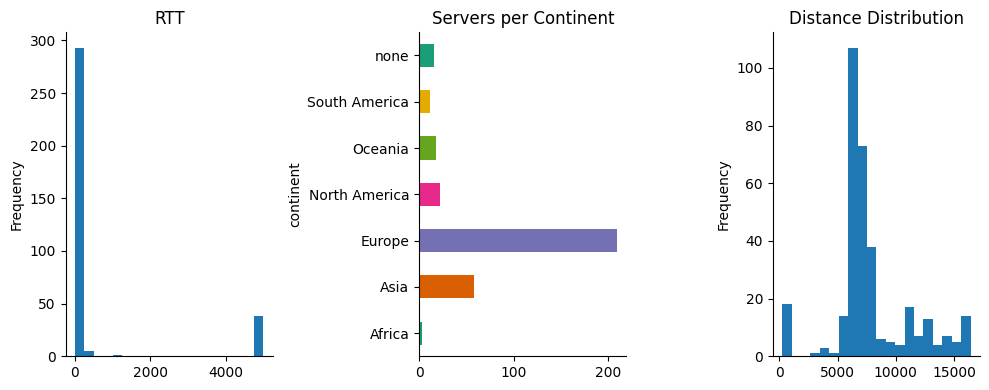

In [81]:
display_dataset(servers_df)

Here we can see the relationship between Distance and Round Trip Time by
creating a scatter plot of the corresponding values. RTT values are plotted on the y-axis and distance values on the x-axis
Grid lines are added to the plot for better visualization.

The presence of the outliers can be seen clearly in the left-hand side scatter plot, as some servers did not response to the ping command. I removed them and also the one which has a RTT value more than 1 second from the dataset to reveal a real correlation between the distance and RTT of pingable servers. You can see the result of cleaned dataset in the righ-hand side scatter plot.

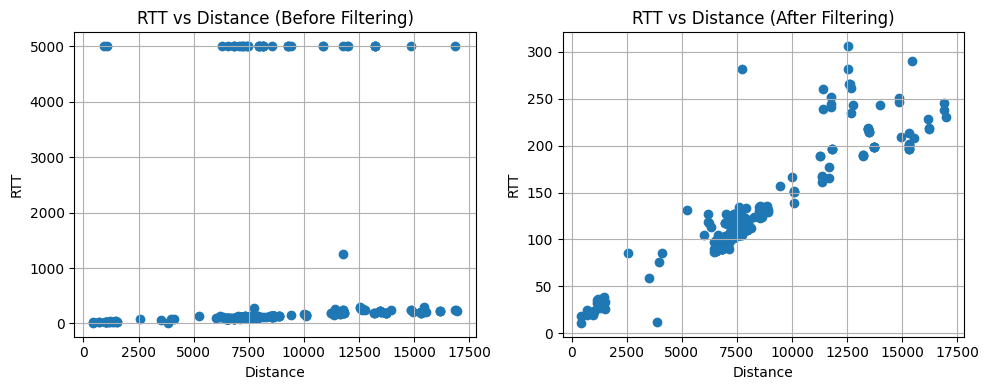

In [10]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot of RTT versus distance (before filtering)
distance_list = servers_df["distance"]
rtt_list = servers_df["rtt"]
axs[0].scatter(distance_list, rtt_list)
axs[0].set_title('RTT vs Distance (Before Filtering)')
axs[0].set_xlabel('Distance')
axs[0].set_ylabel('RTT')
axs[0].grid(True)

# Filter out timeout requests and create a scatter plot of RTT versus distance (after filtering)
filtered_df = servers_df[servers_df["rtt"] <= 1000]
distance_list_filtered = filtered_df["distance"]
rtt_list_filtered = filtered_df["rtt"]
axs[1].scatter(distance_list_filtered, rtt_list_filtered)
axs[1].set_title('RTT vs Distance (After Filtering)')
axs[1].set_xlabel('Distance')
axs[1].set_ylabel('RTT')
axs[1].grid(True)

# Adjust layout spacing
plt.tight_layout()

# Show the plots
plt.show()


**Outlier Removal**

All the rows which has rtt lower than 1000 ms are filtered. the distribution of RTT, Distance and the number of servers per continent in the cleaned dataset are illustrated in the following bar charts. Now it is clearly revealed that the majority of RTT values is around 100 ms.

Number of removed rows:  39


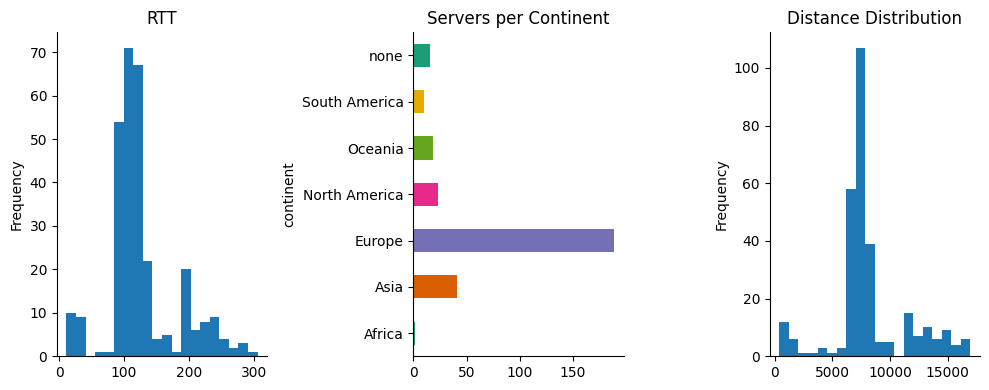

In [11]:
filtered_df = servers_df[servers_df["rtt"] <= 1000]
print("Number of removed rows: ", servers_df.shape[0] - filtered_df.shape[0])

# From now, I work with the filtered data set
servers_df = filtered_df
distance_list = servers_df["distance"]
rtt_list = servers_df["rtt"]

# Visualization of filtered data set main features
display_dataset(servers_df)

To know the farthest and nearest servers, the following block of code is written and the results are reported.

It can be clearly seen that the farthest server which is located in Indonesia in a 16423 km distance replies with a long delay, 237 ms. You can see from the bar chart above, this amount of RTT value is one of the highest RTT values among the servers I considered.

On the other side, the nearest server is located in the same country, the United states, as the reference server exist, in a distance of 274 km. The average value of RTT for this server is registered just 2 ms.

In [12]:
# Find the row with the maximum Distance value
max_rtt_row = servers_df.loc[servers_df['distance'].idxmax()]

# Extract other parameters
far_country   = max_rtt_row['country']
far_city      = max_rtt_row['city']
far_distance  = max_rtt_row['distance']
far_rtt       = max_rtt_row['rtt']
far_latitude  = max_rtt_row['latitude']
far_longitude = max_rtt_row['longitude']

print("The farthest server is located in: ")
print(f"Country:       {far_country}")
print(f"City:          {far_city}")
print(f"Distance:      {far_distance} km")
print(f"RTT:           {far_rtt} ms")
print(f"Latitude:      {far_latitude}")
print(f"Longitude:     {far_longitude}")

# Find the row with the minimum Distance value
min_rtt_row = servers_df.loc[servers_df['distance'].idxmin()]

# Extract other parameters
near_country   = min_rtt_row['country']
near_city      = min_rtt_row['city']
near_distance  = min_rtt_row['distance']
near_rtt       = min_rtt_row['rtt']
near_latitude  = min_rtt_row['latitude']
near_longitude = min_rtt_row['longitude']

print("\n")
print("The nearest server is located in: ")
print(f"Country:       {near_country}")
print(f"City:          {near_city}")
print(f"Distance:      {near_distance} km")
print(f"RTT:           {near_rtt} ms")
print(f"Latitude:      {near_latitude}")
print(f"Longitude:     {near_longitude}")

The farthest server is located in: 
Country:       Indonesia
City:          Bekasi
Distance:      16972 km
RTT:           230 ms
Latitude:      -6.26
Longitude:     106.94


The nearest server is located in: 
Country:       United States
City:          Atlanta
Distance:      419 km
RTT:           11 ms
Latitude:      33.75
Longitude:     -84.39


To have a better visualization of distribution of the servers' locations, they are illustrated on the map using the benefits of folium library. You can see the location of reference server in red and the distance servers in blue. Furthermore, to make more sense, I drew two lines in green and black to show the farthest and the nearest servers w.r.t the reference server, respectively.

In [13]:
# Create a folium Map object with a smaller size and set the center
servers_map = folium.Map(location=[servers_df['latitude'].mean(), servers_df['longitude'].mean()], zoom_start=3, control_scale=True, width='80%', height='80%')

# Add all the servers in blue
for index, row in servers_df.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=2, color='blue', fill=True, fill_color='blue', popup=row['ip']).add_to(servers_map)

# Add the reference server location by a red circle to the map
ref_point = folium.CircleMarker(location=my_coordinate, radius=5, color='red', fill=True, fill_color='red')
ref_point.add_to(servers_map)

# Draw a green line between the reference server and the farthest server
folium.PolyLine(locations=[my_coordinate, [far_latitude, far_longitude]], color='green', weight=2, opacity=0.6).add_to(servers_map)

# Draw a black line between the reference server and the farthest server
folium.PolyLine(locations=[my_coordinate, [near_latitude, near_longitude]], color='black', weight=2, opacity=0.6).add_to(servers_map)

# Show the map
servers_map

#**Part 4: Data Analysis**

In this project, linear regression plays a crucial role in analyzing the relationship between network latency (Round-Trip Time, RTT) and geographical distance. By fitting a polynomial regression line to the data, I could model how RTT changes as the distance between endpoints varies. In the provided code, a polynomial regression line is fitted to the scatter plot of RTT measurements against distance. This allows us to visualize the linear relationship between RTT and distance, represented by the red fitted line on the scatter plot. Through this analysis, we gain insights into how RTT changes predictably with increasing distance.

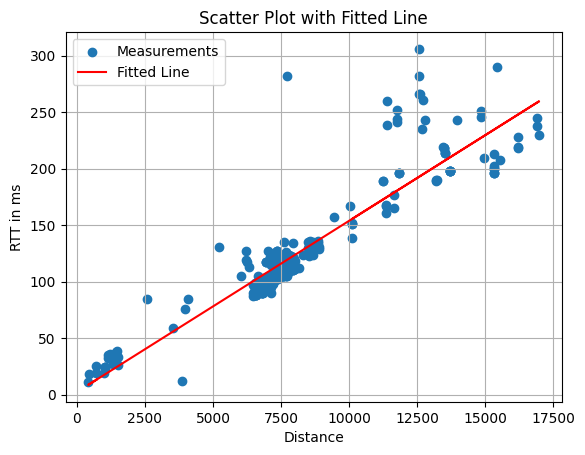

In [14]:
# Fit a polynomial regression line
degree = 1  # Set the degree of the polynomial (linear regression)
coefficients = np.polyfit(distance_list, rtt_list, degree)

# Generate y values for the fitted line
fitted_line_y = np.polyval(coefficients, distance_list)

# Create scatter plot
plt.scatter(distance_list, rtt_list, label='Measurements')

# Plot the fitted line
plt.plot(distance_list, fitted_line_y, color='red', label='Fitted Line')

# Add labels, title, and legend
plt.xlabel('Distance')
plt.ylabel('RTT in ms')
plt.title('Scatter Plot with Fitted Line')
plt.legend()

# Display plot
plt.grid(True)  # Add grid for better visualization
plt.show()


#**Part 5: Model Evaluation**

In following 2 blocks of code, main statistical information of RTT and Distance are reported. In addition, some important and relevant evaluation metrics are calculated to assess the performance of the linear regression model:

* R-squared: Measures the proportion of the variance in the dependent variable (RTT) that is predictable from the independent variable (distance). It ranges from 0 to 1, where 1 indicates a perfect fit.
* Mean Squared Error (MSE): Measures the average squared difference between the actual and predicted values. Lower values indicate better model performance.
* Mean Absolute Error (MAE): Measures the average absolute difference between the actual and predicted values. Lower values indicate better model performance.


In [92]:
# Display main statistical information of the RTT
rtt_stats = servers_df['rtt'].describe()
print("RTT statistics")
print(rtt_stats)

print("\n")

# Display main statistical information of the Distance
distance_stats = servers_df['distance'].describe()
print("Distance statistics")
print(rtt_stats)

RTT statistics
count    298.000000
mean     117.751678
std       52.582647
min        2.000000
25%       89.250000
50%      102.000000
75%      125.000000
max      268.000000
Name: rtt, dtype: float64


Distance statistics
count    298.000000
mean     117.751678
std       52.582647
min        2.000000
25%       89.250000
50%      102.000000
75%      125.000000
max      268.000000
Name: rtt, dtype: float64


In [17]:
# Calculate R-squared value
r_squared = r2_score(rtt_list, fitted_line_y)
print("R-squared:", round(r_squared, 4))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(rtt_list, fitted_line_y)
print("Mean Squared Error (MSE):", round(mse, 4))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(rtt_list, fitted_line_y)
print("Mean Absolute Error (MAE):", round(mae, 4))


R-squared: 0.8333
Mean Squared Error (MSE): 477.2653
Mean Absolute Error (MAE): 13.5444


#**Part 6: Conclusion**

In conclusion, this project comprehensively evaluated the relationship between average Round-Trip Time (RTT) and physical distance of two endpoints. Through the analysis of data collected from approximately 300 servers worldwide, key insights were gained into how network latency varies with distance.

Statistical information on RTT and distance further supported the findings, showing consistent trends and variability across the dataset. The descriptive statistics highlighted the distribution and characteristics of RTT and distance values, providing context for the analysis.

The analysis revealed a strong linear relationship between RTT and physical distance, as evidenced by the high R-squared value of 0.8333. This suggests that approximately 83.33% of the variability in RTT can be explained by the linear relationship with distance. The linear regression model fitted to the data provided a reliable estimate of RTT based on distance, with relatively low errors indicated by the Mean Squared Error (MSE) and Mean Absolute Error (MAE) values.

Althogh there is a theoretical formula which can be used to compute the exact value of RTT, we can see from the experiment's results that geographical distance plays a pivotal role and in has a huge influence on the RTT value. The importance of distance on the RTT makes other parameters such as packet length (L), velocity of propagation (v), and bandwidth (C), to have a negligible impact on the RTT value. Therefore, I can say that the experiment follows the RTT formula by focusing on the distance parameter as the most important one.

RTT = 2(L/C + d/v) + n

Overall, this project contributes valuable insights into the dynamics of network latency and its relationship with physical distance. Understanding these relationships is crucial for optimizing network performance, designing efficient communication systems, and improving user experience in various applications and industries.